# Meta Labeling
This notebook is a small MVP regarding the idea of meta labeling by Marcos Lopez de Prado, Advances in Financial Machine Learning, Chapter 3, pg 50. 

The central idea is to create a secondary ML model that learns how to use the primary exogenous model. This leads to improved performance metrics, including: Accuracy, Precision, Recall, and F1-Score.

To illustrate the concept we made use of the MNIST data set to train a binary classifier on identifying the number 8, from a set that only includes the digits 8 and 3. The reason for this is that the number 3 looks very similar to 8 and we expect there to be some overlap in the data, i.e. the data are not linearly separable. Another reason we chose the MNIST dataset to illustrate the concept, is that MNIST is a solved problem and we can witness improvements in performance metrics with ease. 

## Questions
What exactly is meta labeling doing? I've bounced a few ideas around but I haven't got a clear answer (I'll share some of them as we progress). I'd love to hear some feedback from the community and create a conversation.

## Papers
The following papers were mentioned in the Bibliography, that highlight some of the inspiration for metalabeling. 
* [Patel, J., Shah, S., Thakkar, P. and Kotecha, K., 2015. Predicting stock market index using fusion of machine learning techniques. Expert Systems with Applications, 42(4), pp.2162-2172.](https://www.sciencedirect.com/science/article/pii/S0957417414006551)
* [Tsai, C.F. and Wang, S.P., 2009, March. Stock price forecasting by hybrid machine learning techniques. In Proceedings of the International MultiConference of Engineers and Computer Scientists (Vol. 1, No. 755, p. 60).](https://pdfs.semanticscholar.org/0fb3/9b308ec17401ec5697139dcf7f832080179f.pdf)
* [Zhu, M., Philpotts, D., Sparks, R. and Stevenson, M.J., 2011. A hybrid approach to combining CART and logistic regression for stock ranking. Journal of Portfolio Management, 38(1), p.100.](https://search.proquest.com/openview/65025597d6bcc7b430cb9c41ddfdf203/1?pq-origsite=gscholar&cbl=49137)


### His book reads:
#### Meta Labeling
Suppose that you have a model for setting the side of the bet (long or short). You just need to learn the size of that bet, which includes the possibility of no bet at all (zero size). This is a situation that practitioners face regularly. We often know whether we want to buy or sell a product, and the only remaining question is how much money we should risk in such a bet. We do not want the ML algorithm to learn the side, just to tell us what is the appropriate size. At this point, it probably does not surprise you to hear that no book or paper has so far discussed this common problem. Thankfully, that misery ends here.

I call this problem meta-labeling because we want to build a secondary ML model that learns how to use a primary exogenous model. 

The ML algorithm will be trained to decide whether to take the bet or pass, a purely binary prediction. When the predicted label is 1, we can use the probability of this secondary prediction to derive the size of the bet, where the side (sign) of the position has been set by the primary model.

#### How to use Meta-Labeling
Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

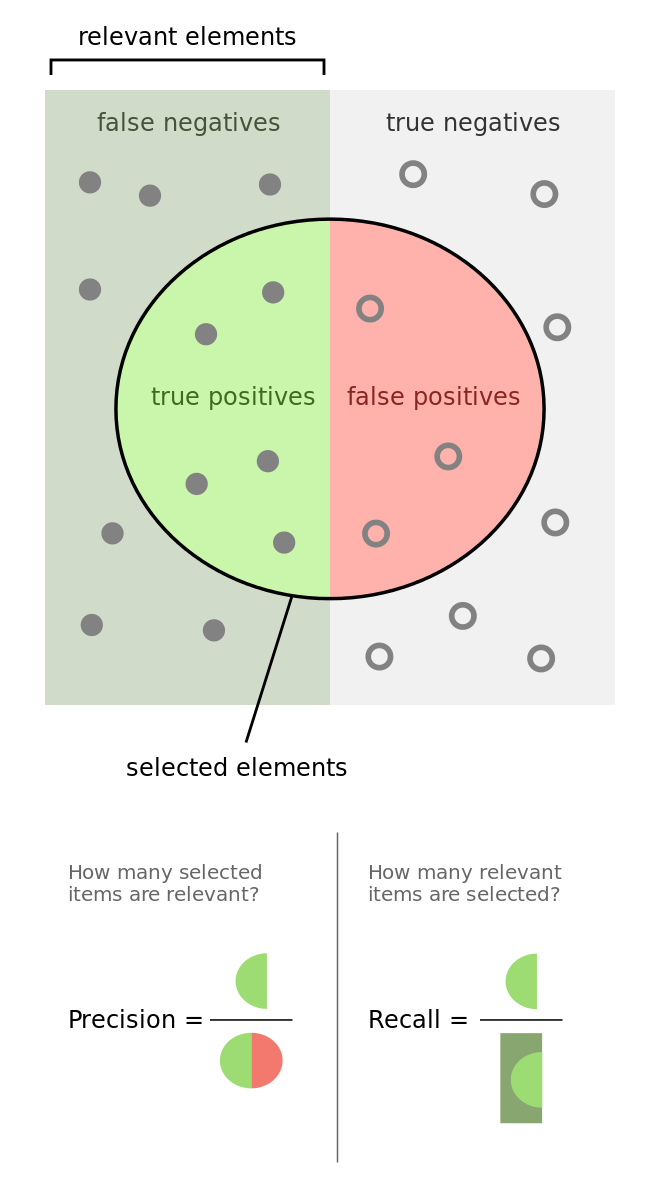

In [1]:
from IPython.core.display import Image, display
display(Image('https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/660px-Precisionrecall.svg.png', width=300, unconfined=True))

The image above illustrates the so-called “confusion matrix.” On a set of observations, there are items that exhibit a condition (positives, left rectangle), and items that do not
exhibit a condition (negative, right rectangle). A binary classifier predicts that some items exhibit the condition (ellipse), where the TP area contains the true positives and the TN area contains the true negatives. This leads to two kinds of errors: false positives (FP) and false negatives (FN). “Precision” is the ratio between the TP area and the area in the ellipse. “Recall” is the ratio between the TP area and the area in the left rectangle. This notion of recall (aka true positive rate) is in the context of classification problems, the analogous to “power” in the context of hypothesis testing. “Accuracy” is the sum of the TP and TN areas divided by the overall set of items (square). In general, decreasing the FP area comes at a cost of increasing the FN area, because higher precision typically means fewer calls, hence lower recall. Still, there is some combination of precision and recall that maximizes the overall efficiency of the classifier. The F1-score measures the efficiency of a classifier as the harmonic average between precision and recall.

**Meta-labeling is particularly helpful when you want to achieve higher F1-scores**. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase your F1-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is *not* its purpose to come up with a betting opportunity. Its purpose is to determine whether we should act or pass on the opportunity that has been presented.

Meta-labeling is a very powerful tool to have in your arsenal, for four additional reasons. **First**, ML algorithms are often criticized as black boxes.
Meta-labeling allows you to build an ML system on top of a white box (like a fundamental model founded on economic theory). This ability to transform a fundamental model into an ML model should make meta-labeling particularly useful to “quantamental” firms. **Second**, the effects of overfitting are limited when you apply metalabeling,
because ML will not decide the side of your bet, only the size. **Third**, by decoupling the side prediction from the size prediction, meta-labeling enables sophisticated
strategy structures. For instance, consider that the features driving a rally may differ from the features driving a sell-off. In that case, you may want to develop an
ML strategy exclusively for long positions, based on the buy recommendations of a primary model, and an ML strategy exclusively for short positions, based on the
sell recommendations of an entirely different primary model. **Fourth**, achieving high accuracy on small bets and low accuracy on large bets will ruin you. As important as
identifying good opportunities is to size them properly, so it makes sense to develop an ML algorithm solely focused on getting that critical decision (sizing) right. We will
retake this fourth point in Chapter 10. In my experience, meta-labeling ML models can deliver more robust and reliable outcomes than standard labeling models.

---
# MVP Using MNIST Data

#### Imports:

In [2]:
import numpy as np 
import pandas as pd
from collections import Counter
import itertools
import seaborn as sns
from subprocess import check_output
from sklearn import metrics as sk_metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


#### Functions:

In [4]:
def plot_roc(actual, prediction):
    # Calculate ROC / AUC
    fpr, tpr, thresholds = sk_metrics.roc_curve(actual, prediction, pos_label=1)
    roc_auc = sk_metrics.auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def test_meta_label(primary_model, secondary_model, x, y, threshold):
    """
    Function outputs the results of the primary model with a threshold of 50%. It then outputs the results of the meta model.
    Ideally you want to see that the meta model out performs the primary model.

    I am busy investigating why meta modeling works. A little tricky since I'm yet to find a solid paper on the technique. Its very briefly mentioned in
    Advances in Financial Machine Learning.

    :param primary_model: model object (First, we build a model that achieves high recall, even if the precision is not particularly high)
    :param secondary_model: model object (the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model
                            is true or false. It is not its purpose to come up with a betting opportunity. Its purpose is to determine whether
                            we should act or pass on the opportunity that has been presented.)
    :param x: Explanatory variables
    :param y: Target variable (One hot encoded)
    :param threshold: The confidence threshold. This is used
    :return: Print the classification report for both the base model and the meta model.
    """
    actual = np.array([i[1] for i in y]) == 1

    primary_prediction = primary_model.predict(x)
    primary_prediction = np.array([i[1] for i in primary_prediction]).reshape((-1, 1))
    primary_prediction_int = primary_prediction > threshold

    # Print output for base model
    print('Base Model Metrics:')
    print(sk_metrics.classification_report(actual, primary_prediction > 0.50))
    # Confusion matrix
    print('Confusion Matrix')
    print(sk_metrics.confusion_matrix(actual, primary_prediction_int))
    accuracy = (actual == primary_prediction_int.flatten()).sum() / actual.shape[0]
    print('Accuracy: ', round(accuracy, 4))
    print('')

    # Secondary model
    new_features = np.concatenate((primary_prediction_int, x), axis=1)

    # Forecast meta
    meta_prediction = secondary_model.predict(new_features)
    meta_prediction = np.array([i[1] for i in meta_prediction])
    meta_prediction_int = meta_prediction > 0.5

    # Now combine primary and secondary model
    final_prediction = (meta_prediction_int & primary_prediction_int.flatten())

    # Print output for meta model
    print('Meta Label Metrics: ')
    print(sk_metrics.classification_report(actual, final_prediction))
    print('Confusion Matrix')
    print(sk_metrics.confusion_matrix(actual, final_prediction))

    accuracy = (actual == final_prediction).sum() / actual.shape[0]
    print('Accuracy: ', round(accuracy, 4))

### Data Exploration
Download the MNIST data set

In [7]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 40s 3us/step


In [8]:
Counter(y_test)

Counter({7: 1028,
         2: 1032,
         1: 1135,
         0: 980,
         4: 982,
         9: 1009,
         5: 892,
         6: 958,
         3: 1010,
         8: 974})

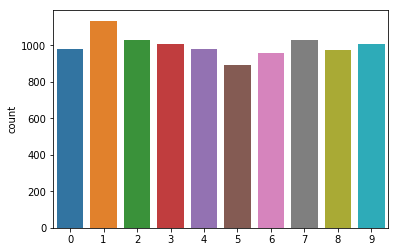

In [9]:
sns.countplot(y_test)

---
### Normalize and subset data
* It is standard practice to normalise the MNIST data by 255.0
* Next we subset the data so that we only include the numbers 8 and 3
* Reshape the data: We will use a feedforward neural net or a logistic regression, for this we can just flatten the images
* One Hot Encode the target variables
* Do a test train split, keep a hold out sample

In [10]:
# Normalising the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [11]:
# Subset on only two numbers 8 and 0
x_sub_train = x_train[(y_train == 8) | (y_train == 3)]
y_sub_train = y_train[(y_train == 8) | (y_train == 3)]

x_sub_test = x_test[(y_test == 8) | (y_test == 3)]
y_sub_test = y_test[(y_test == 8) | (y_test == 3)]

print('X values')
print('x_train', x_sub_train.shape)
print('x_test', x_sub_test.shape, '\n')
print('Y values')
print('y train', y_sub_train.shape)
print('y test', y_sub_test.shape)

X values
x_train (11982, 28, 28)
x_test (1984, 28, 28) 

Y values
y train (11982,)
y test (1984,)


In [12]:
# Flatten input
x_train_flat = x_sub_train.flatten().reshape(x_sub_train.shape[0], 28*28)
x_test_flat = x_sub_test.flatten().reshape(x_sub_test.shape[0], 28*28)

# One hot encode target variables
y_sub_train_encoded = to_categorical([1 if value == 8 else 0 for value in y_sub_train])

# Test train split
X_train, X_val, Y_train, Y_val = train_test_split(x_train_flat, y_sub_train_encoded, test_size = 0.1, random_state=42)

---
### Build Primary Model with High Recall

In [13]:
# Build primary model
model = Sequential()
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=1, batch_size=320) # batch size is so large so that the model can be poorly fit, Its easy to get 99% accuracy.

Train on 10783 samples, validate on 1199 samples
Epoch 1/1
10783/10783 [==============================] - 0s 29us/step - loss: 0.5599 - acc: 0.7353 - val_loss: 0.4432 - val_acc: 0.8540


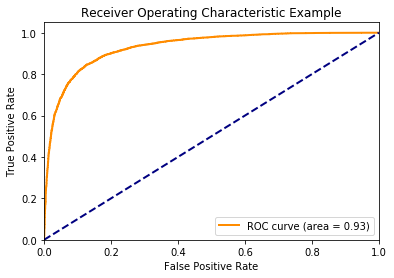

In [14]:
# Plot ROC
prediction = model.predict(X_train)
prediction = np.array([i[1] for i in prediction])
actual = np.array([i[1] for i in Y_train]) == 1

plot_roc(actual, prediction)

In [15]:
# Create a model with high recall, change the threshold until a good recall level is reached
threshold = .35
prediction_int = np.array(prediction) > threshold

# Classification report
print(sk_metrics.classification_report(actual, prediction_int))

# Confusion matrix
cm = sk_metrics.confusion_matrix(actual, prediction_int)
print('Confusion Matrix')
print(cm)

              precision    recall  f1-score   support

       False       0.95      0.56      0.71      5512
        True       0.68      0.97      0.80      5271

   micro avg       0.76      0.76      0.76     10783
   macro avg       0.82      0.77      0.75     10783
weighted avg       0.82      0.76      0.75     10783

Confusion Matrix
[[3088 2424]
 [ 150 5121]]


### Build Meta Model

In [16]:
# Get meta labels
meta_labels = prediction_int & actual
meta_labels_encoded = to_categorical(meta_labels)

In [17]:
# Reshape data
prediction_int = prediction_int.reshape((-1, 1))

# MNIST data + forecasts_int
new_features = np.concatenate((prediction_int, X_train), axis=1)

In [18]:
# Train a new model 
# Build model
meta_model = Sequential()
meta_model.add(Dense(units=2, activation='softmax'))

meta_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
meta_model.fit(x=new_features, y=meta_labels_encoded, epochs=1, batch_size=32)

Epoch 1/1
10783/10783 [==============================] - 1s 84us/step - loss: 0.2274 - acc: 0.9188


### Evaluate performance on Train data

In [19]:
test_meta_label(primary_model=model, secondary_model=meta_model, x=X_train, y=Y_train, threshold=threshold)

Base Model Metrics:
              precision    recall  f1-score   support

       False       0.88      0.83      0.85      5512
        True       0.83      0.88      0.86      5271

   micro avg       0.86      0.86      0.86     10783
   macro avg       0.86      0.86      0.86     10783
weighted avg       0.86      0.86      0.86     10783

Confusion Matrix
[[3088 2424]
 [ 150 5121]]
Accuracy:  0.7613

Meta Label Metrics: 
              precision    recall  f1-score   support

       False       0.94      0.96      0.95      5512
        True       0.96      0.94      0.95      5271

   micro avg       0.95      0.95      0.95     10783
   macro avg       0.95      0.95      0.95     10783
weighted avg       0.95      0.95      0.95     10783

Confusion Matrix
[[5281  231]
 [ 315 4956]]
Accuracy:  0.9494


### Evaluate performance on Val Data

In [20]:
test_meta_label(primary_model=model, secondary_model=meta_model, x=X_val, y=Y_val, threshold=threshold)

Base Model Metrics:
              precision    recall  f1-score   support

       False       0.88      0.83      0.85       619
        True       0.83      0.88      0.85       580

   micro avg       0.85      0.85      0.85      1199
   macro avg       0.85      0.85      0.85      1199
weighted avg       0.86      0.85      0.85      1199

Confusion Matrix
[[346 273]
 [ 12 568]]
Accuracy:  0.7623

Meta Label Metrics: 
              precision    recall  f1-score   support

       False       0.95      0.96      0.95       619
        True       0.96      0.94      0.95       580

   micro avg       0.95      0.95      0.95      1199
   macro avg       0.95      0.95      0.95      1199
weighted avg       0.95      0.95      0.95      1199

Confusion Matrix
[[594  25]
 [ 34 546]]
Accuracy:  0.9508


---
### Evaluate performance on Hold out

In [21]:
# Flatten input
x_test_flat = x_sub_test.flatten().reshape(x_sub_test.shape[0], 28*28)

# One hot encode target variables
y_sub_test_encoded = to_categorical([1 if value == 8 else 0 for value in y_sub_test])

In [22]:
test_meta_label(primary_model=model, secondary_model=meta_model, x=x_test_flat, y=y_sub_test_encoded, threshold=threshold)

Base Model Metrics:
              precision    recall  f1-score   support

       False       0.85      0.86      0.86      1010
        True       0.85      0.85      0.85       974

   micro avg       0.85      0.85      0.85      1984
   macro avg       0.85      0.85      0.85      1984
weighted avg       0.85      0.85      0.85      1984

Confusion Matrix
[[630 380]
 [ 28 946]]
Accuracy:  0.7944

Meta Label Metrics: 
              precision    recall  f1-score   support

       False       0.95      0.96      0.95      1010
        True       0.96      0.94      0.95       974

   micro avg       0.95      0.95      0.95      1984
   macro avg       0.95      0.95      0.95      1984
weighted avg       0.95      0.95      0.95      1984

Confusion Matrix
[[974  36]
 [ 56 918]]
Accuracy:  0.9536


---
## Conclusion
It would seem that meta labeling is working as advertised. However its not clear to me why it is working. 

We can see that in the confusion matrix, that the FP from the primary model, are now being correctly identified as TN with the help of meta labeling. 